# Dynamic Training with Skipgram
In this notebook we train the predictions model together with skipgram dynamically. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc
import os, sys, time
from importlib import reload
%matplotlib inline

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from keras.layers import Input, Embedding, Concatenate, Reshape, BatchNormalization, LSTM, CuDNNLSTM, CuDNNGRU, Lambda
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.initializers import Constant
import keras.backend as K
import tensorflow as tf

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import get_frequency, preprocess

Using TensorFlow backend.


In [5]:
from ccs_tools import dx_multi, pr_multi, core_dtypes_pd

## Data Preparation

In [6]:
cohort='ami'
tst_seed=0

In [7]:
all_df = pd.read_csv(path+'cohorts/{}/{}_pred.csv'.format(cohort, cohort), dtype=core_dtypes_pd)

In [8]:
n_DX = 29
n_PR = 15
DXs = ['DX'+str(n) for n in range(2, n_DX+2)]
PRs = ['PR'+str(n) for n in range(1, n_PR+1)]

In [9]:
preprocessed = preprocess(all_df, DX_rarecutpoint=20, PR_rarecutpoint=20)

In [10]:
all_df = preprocessed['int_df']

In [11]:
tst_key = pd.read_csv(path+'cohorts/{}/tst_key{}.csv'.format(cohort, tst_seed), names = ['KEY_NRD'])
tst_df = all_df.loc[all_df.KEY_NRD.isin(tst_key.KEY_NRD)]
train_df0 = all_df.loc[~all_df.KEY_NRD.isin(tst_key.KEY_NRD)].reset_index()

In [12]:
train_df0.shape, all_df.shape

((167841, 180), (187055, 179))

### Data formating

In [12]:
DX1_cat = preprocessed['DX1_cat']
DX_cat = preprocessed['DX_cat']
PR_cat = preprocessed['PR_cat']
DX1_dict = preprocessed['DX1_dict']
DX_dict = preprocessed['DX_dict']
PR_dict = preprocessed['PR_dict']
code_cat = preprocessed['code_cat']
hosp_cat = preprocessed['hosp_cat']
age_mean = train_df0['AGE'].mean()
age_std = train_df0['AGE'].std()
los_mean = train_df0['LOS'].mean()
los_std = train_df0['LOS'].std()

DX1_array_tst = tst_df['DX1'].values
DX_mat_tst = tst_df[DXs].values
PR_mat_tst = tst_df[PRs].values

hosp_array_tst = tst_df['HOSP_NRD'].values
    
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std
pay1_mat_tst = to_categorical(tst_df.PAY1.values)[:, 1:]
los_array_tst = (tst_df.LOS.values - los_mean)/los_std
ed_mat_tst = to_categorical(tst_df.HCUP_ED.values)
zipinc_mat_tst = to_categorical(tst_df.ZIPINC_QRTL.values)[:, 1:]
#transfer_mat_tst = to_categorical(tst_df.SAMEDAYEVENT.values)
other_mat_tst = np.concatenate((demo_mat_tst, pay1_mat_tst, los_array_tst.reshape(los_array_tst.shape+(1,)), 
                                ed_mat_tst, zipinc_mat_tst), axis=1)
y_true = tst_df.readm30.astype(int).values

In [13]:
train_df = train_df0.copy()

In [73]:
mat_train = train_df[['DX1']+DXs+PRs].values
labels_flatten = np.concatenate((mat_train,np.repeat(mat_train,29,axis=1),np.repeat(mat_train,15,axis=1)),axis=1)

In [22]:
mat_train.shape, labels_flatten.shape, labels_flatten.nbytes

((167841, 45), (167841, 2025), 2719024200)

In [15]:
#Construct conditions according to labels_flatten
conditions = labels_flatten != 0
# labels = 0 then conditions = 0
conditions = conditions.astype(int)
# same index pair corresponding to 0
# index of x is 0 and index of y is 0
conditions[:,0] = 0
# index of x from 1 to 29 and the index of same y in labels
for i in range(0,29):
    conditions[:,74+30*i] = 0
# index of x from 30 to 44
for i in range(0,15):
    conditions[:, 1800+16*i] = 0
# index where embed input = 0 
nn = mat_train.shape[0]
for i in range(nn):
    for j in range(1,30):
        if mat_train[i,j] == 0:
            for k in range(45):
                conditions[i,45+29*k+j-1] = 0
    for j in range(30,45):
        if mat_train[i,j] == 0:
            for k in range(45):
                conditions[i,1350+15*k+j-30] = 0            

In [16]:
n_fold = 5

In [17]:
skf = StratifiedKFold(n_splits=n_fold, random_state=24, shuffle=True)

In [18]:
trn_idx, val_idx = next(skf.split(train_df, train_df0.HOSP_NRD))

In [19]:
DX1_array_train = train_df['DX1'].values
            
DX1_array_trn = DX1_array_train[trn_idx]
DX1_array_val = DX1_array_train[val_idx]

DX_mat_train = train_df[DXs].values
            
DX_mat_trn = DX_mat_train[trn_idx, :]
DX_mat_val = DX_mat_train[val_idx, :]

PR_mat_train = train_df[PRs].values
            
PR_mat_trn = PR_mat_train[trn_idx, :]
PR_mat_val = PR_mat_train[val_idx, :]

In [20]:
hosp_array_train = train_df['HOSP_NRD'].values
    
hosp_array_trn = hosp_array_train[trn_idx]
hosp_array_val = hosp_array_train[val_idx]

In [21]:
demo_mat_train = train_df[['AGE', 'FEMALE']].values
demo_mat_train[:, 0] = (demo_mat_train[:, 0]-age_mean)/age_std
pay1_mat_train = to_categorical(train_df.PAY1.values)[:, 1:]
los_array_train = (train_df.LOS.values - los_mean)/los_std
ed_mat_train = to_categorical(train_df.HCUP_ED.values)
zipinc_mat_train = to_categorical(train_df.ZIPINC_QRTL.values)[:, 1:]
#transfer_mat_train = to_categorical(train_df.SAMEDAYEVENT.values)
other_mat_train = np.concatenate((demo_mat_train, pay1_mat_train, los_array_train.reshape(los_array_train.shape+(1,)), 
                                ed_mat_train, zipinc_mat_train), axis=1)

other_mat_trn = other_mat_train[trn_idx, :]
other_mat_val = other_mat_train[val_idx, :]

y_train = train_df.readm30.astype(int).values
y_trn = y_train[trn_idx]
y_val = y_train[val_idx]
Y_trn = to_categorical(y_train[trn_idx])
Y_val = to_categorical(y_train[val_idx])

In [22]:
labels_flatten_train = labels_flatten[trn_idx,:]
labels_flatten_val = labels_flatten[val_idx,:]
conditions_train = conditions[trn_idx,:]
conditions_val = conditions[val_idx,:]

In [23]:
n_disease=len(DX1_cat)+len(DX_cat)+len(PR_cat)+1

In [90]:
code_embed_dim = 100
md_width = 128
fc_width = 512
hosp_embed_dim = 1
dropout = 0.3
job_index = 0
batchsize = 512
n_samples=100
lamb = 1.

In [26]:
embed_mat=np.random.uniform(0,1,size=[n_disease,code_embed_dim])
embed_initializer = Constant(embed_mat)

### Model Building

In [75]:
from keras.engine.topology import Layer
from keras import objectives

def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)


class SkipgramRegularization(Layer):
    """Layer written by Wenyi to do dynamic training with skipgram. 
    """
    def __init__(self, num_samples, num_classes, lamb, **kwargs):
        self.num_samples = num_samples #number of netagive sample
        self.num_classes = num_classes #number of code categories
        self.lamb = lamb #tuning parameter to control the weight between skipgram and prediction model
        super(SkipgramRegularization, self).__init__(**kwargs)
        
    def build(self, input_shape):
        dx0_shape, dx_shape,pr_shape, label_flatten_shape,input_conditions_shape = input_shape
        self.kernel = self.add_weight(name='kernel',
                                      shape=(self.num_classes, dx0_shape[2]),
                                      initializer='uniform',
                                      trainable=True)
        self.bias = self.add_weight(name='bias',
                                    shape=(self.num_classes,),
                                    initializer='uniform',
                                    trainable=True) 
        super(SkipgramRegularization, self).build(input_shape)

    def call(self,x):
        dx0_embed, dx_embed, pr_embed, labels_flatten,input_conditions = x
        inputs_in = tf.concat([dx0_embed,dx_embed,pr_embed],axis=1)
        inputs_in = tf.cast(inputs_in, tf.float32)
        #labels_in1 = tf.cast(labels_in, tf.float32)
        total_loss = 0
        n_codes = 2
        #labels_in = tf.gather(labels_flatten,list(np.arange(0,45)),axis=1)
        inputs_in = tf.concat([tf.tile(dx0_embed,[1,45,1]),tf.tile(dx_embed,[1,45,1]),tf.tile(pr_embed,[1,45,1])],axis=1)
        inputs_reshape = tf.reshape(inputs_in,[-1,dx_embed.shape[2]])
        labels_reshape = tf.reshape(labels_flatten,[-1,1])
        conditions_reshape = tf.reshape(input_conditions,[-1,1])
        loss = tf.nn.sampled_softmax_loss(
                             weights = self.kernel,
                             biases = self.bias,
                             labels = labels_reshape,
                             inputs = inputs_reshape,
                             num_sampled=self.num_samples,
                             num_classes=self.num_classes,
                             num_true=1)
        loss = tf.reshape(loss, [-1,1])
        loss = tf.multiply(loss,conditions_reshape)
        non_zero = tf.cast(tf.count_nonzero(loss),tf.float32)
        cost = tf.reduce_sum(loss)/non_zero
        self.add_loss(cost,x)
        return cost

    def compute_output_shape(self, input_shape):
        dx0_shape, dx_shape,pr_shape,label_flatten_shape,input_conditions_shape= input_shape
        return (dx0_shape[0],)

In [28]:
from setsum_layer import SetSum, MaskedSum, MaskedDense, MaskedPooling

In [29]:
numvar=45

In [32]:
embed_initializer = Constant(embed_mat)

In [21]:
embed_initializer = 'uniform'

Model building: 
- setsum_nn 
- setsum_lr
- embed_sum
- embed_pool

In [30]:
from setsum_layer import SkipgramRegularization, zero_loss

In [ ]:
tf.reset_default_graph()

In [111]:
input_DX1 = Input(shape=(1,))
DX1_embed0 = Embedding(input_dim=embed_mat.shape[0], output_dim=code_embed_dim, embeddings_initializer=embed_initializer, 
                      name='DX1_embed')(input_DX1)
DX1_embed = Reshape((code_embed_dim,))(DX1_embed0)

input_DX = Input(shape = (len(DXs),))
DX_embed0 = Embedding(input_dim=embed_mat.shape[0], output_dim=code_embed_dim, mask_zero=False, embeddings_initializer=embed_initializer, 
                     name='DX_embed')(input_DX)
DX_embed = MaskedDense(md_width, activation='relu')(DX_embed0)
DX_embed = MaskedSum()(DX_embed0)

input_PR = Input(shape = (len(PRs),))
PR_embed0 = Embedding(input_dim=embed_mat.shape[0], output_dim=code_embed_dim, mask_zero=False, embeddings_initializer=embed_initializer, 
                     name='PR_embed')(input_PR)
PR_embed = MaskedDense(md_width, activation='relu')(PR_embed0)
PR_embed = MaskedSum()(PR_embed0)

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)
input_other = Input(shape=(other_mat_train.shape[1], ))

merged = Concatenate(axis=1)([DX1_embed, DX_embed, PR_embed, hosp_embed, input_other])
input_labels_flatten = Input(shape=(2025, ))
input_conditions = Input(shape=(2025, ))
cr =  SkipgramRegularization(n_samples, n_disease, 0.001)([DX1_embed0, DX_embed0, PR_embed0, input_labels_flatten, 
                                                           input_conditions])

merged = Dense(fc_width, activation='relu')(merged)
merged = Dropout(dropout)(merged)
prediction = Dense(2, activation='softmax', name='prediction')(merged)
model = Model(inputs=[input_DX1, input_DX, input_PR, input_hosp, input_other,input_labels_flatten,input_conditions], outputs=[prediction,cr])

In [105]:
from keras_addon import AUCCheckPoint

In [107]:
for l in model.layers:
    if l.name=='DX_embed' or l.name=='PR_embed':
        l.trainable = False

In [112]:
adam = Adam(lr=0.0002)
model.compile(optimizer=adam, loss=[K.binary_crossentropy,zero_loss])

In [113]:
auccheckpoint = AUCCheckPoint(filepath=model_path+'embeding_nn_temp'+str(job_index)+'.h5', 
                              validation_y=[Y_val, np.random.randn(Y_val.shape[0],1)], 
                                 validation_x=[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val, 
                                               labels_flatten_val, conditions_val], 
                              auc_output_idx=[0])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
hist = model.fit([DX1_array_trn, DX_mat_trn, PR_mat_trn, hosp_array_trn, other_mat_trn, labels_flatten_train, conditions_train], 
                 [Y_trn, np.random.randn(Y_trn.shape[0], 1)], batch_size=batchsize, epochs=5, 
                 validation_data=[[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val, labels_flatten_val, 
                                   conditions_val], [Y_val, np.random.randn(Y_val.shape[0],1)]], 
                    callbacks=[auccheckpoint, reduce_lr, earlystop], verbose=1)

Train on 133832 samples, validate on 34009 samples
Epoch 1/5
 59392/133832 [============>.................] - ETA: 1:54 - loss: 4.8342 - prediction_loss: 1.1237 - skipgram_regularization_7_loss: 0.0000e+00

In [45]:
conditions.shape

(167841, 2025)

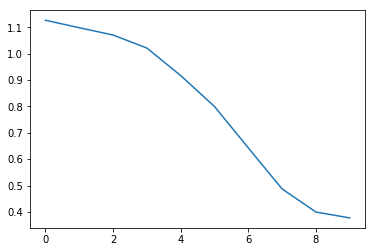

In [30]:
plt.plot(hist.history['val_loss'])

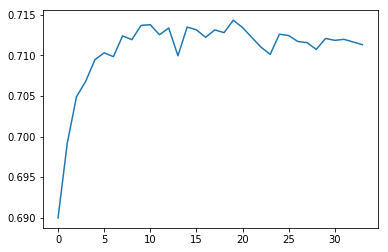

In [40]:
plt.plot(auccheckpoint.auc_history)

In [31]:
model.load_weights(model_path+'embeding_nn_temp'+str(job_index)+'.h5')

In [32]:
y = model.predict([DX1_array_tst, DX_mat_tst, PR_mat_tst, hosp_array_tst, other_mat_tst], verbose=1)

19214/19214 [==============================] - 1s 50us/step


In [33]:
y_pred = y[0][:, 0]
y_true = tst_df.readm30.astype(int).values

{0: 0.7112889554433763}

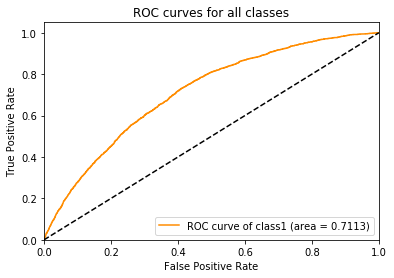

In [34]:
plot_roc(y_pred, y_true)

### Less predictors

In [248]:
model_name = 'setsum_nn'

In [274]:
embed_initializer = 'uniform'

In [249]:
embed_initializer = Constant(embed_mat)

In [250]:
code_embed_dim = 100
md_width = 128

In [286]:
input_DX1 = Input(shape=(1,))
DX1_embed = Embedding(input_dim=len(code_cat), output_dim=code_embed_dim, embeddings_initializer=embed_initializer, 
                      name='DX1_embed')(input_DX1)
DX1_embed = Reshape((code_embed_dim,))(DX1_embed)
input_DX = Input(shape = (len(DXs),))
DX_embed = Embedding(input_dim=len(code_cat), output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer, 
                     name='DX_embed')(input_DX)
if model_name=='setsum_nn' or 'setsum_lr':
    DX_embed = MaskedDense(md_width, activation='relu')(DX_embed)
    DX_embed = MaskedSum()(DX_embed)
elif model_name=='embed_sum':
    DX_embed = MaskedSum()(DX_embed)
elif model_name=='embed_pool':
    DX_embed = MaskedPooling()(DX_embed)
input_PR = Input(shape = (len(PRs),))
PR_embed = Embedding(input_dim=len(code_cat), output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer, 
                     name='PR_embed')(input_PR)
if model_name=='setsum_nn' or 'setsum_lr':
    PR_embed = MaskedDense(md_width, activation='relu')(PR_embed)
    PR_embed = MaskedSum()(PR_embed)
elif model_name=='embed_sum':
    PR_embed = MaskedSum()(PR_embed)
elif model_name=='embed_pool':
    PR_embed = MaskedPooling()(PR_embed)
input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)
input_other = Input(shape=(other_mat_train.shape[1], ))
merged = Concatenate(axis=1)([DX1_embed, DX_embed, PR_embed, hosp_embed])
if model_name=='setsum_nn':
    merged = Dense(fc_width, activation='relu')(merged)
    merged = Dropout(dropout)(merged)
prediction = Dense(2, activation='softmax')(merged)
model = Model(inputs=[input_DX1, input_DX, input_PR, input_hosp], outputs=prediction)

In [287]:
for l in model.layers:
    if l.name=='DX_embed' or l.name=='PR_embed':
        l.trainable = False

In [288]:
adam = Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy')

In [289]:
auccheckpoint = AUCCheckPoint(filepath=model_path+'embeding_nn_temp'+str(job_index)+'.h5', validation_y=Y_val[:, 1], 
                                 validation_x=[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [290]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [291]:
hist = model.fit([DX1_array_trn, DX_mat_trn, PR_mat_trn, hosp_array_trn], Y_trn, 
                     batch_size=batchsize, epochs=30, callbacks=[auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                     validation_data=[[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val], Y_val], 
                    verbose=1)

Train on 133832 samples, validate on 34009 samples
Epoch 1/30
133832/133832 [==============================] - 4s 27us/step - loss: 1.2962 - val_loss: 0.6593
AUC: 0.6928

Epoch 2/30
133832/133832 [==============================] - 2s 14us/step - loss: 1.2701 - val_loss: 0.6217
AUC: 0.6995

Epoch 3/30
133832/133832 [==============================] - 2s 14us/step - loss: 1.2605 - val_loss: 0.6324
AUC: 0.7031

Epoch 4/30
133832/133832 [==============================] - 2s 15us/step - loss: 1.2536 - val_loss: 0.6406
AUC: 0.7056

Epoch 5/30
133832/133832 [==============================] - 2s 15us/step - loss: 1.2472 - val_loss: 0.5979
AUC: 0.7069

Epoch 6/30
133832/133832 [==============================] - 2s 15us/step - loss: 1.2405 - val_loss: 0.6093
AUC: 0.7078

Epoch 7/30
133832/133832 [==============================] - 2s 14us/step - loss: 1.2342 - val_loss: 0.5931
AUC: 0.7070

Epoch 8/30
133832/133832 [==============================] - 2s 14us/step - loss: 1.2295 - val_loss: 0.6434
AU

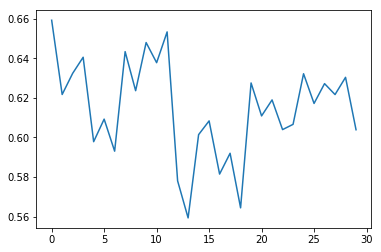

In [292]:
plt.plot(hist.history['val_loss'])

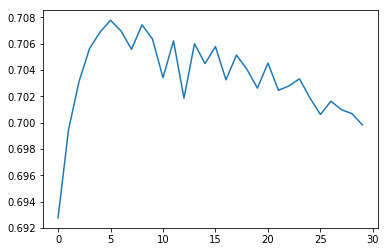

In [293]:
plt.plot(auccheckpoint.auc_history)

In [294]:
model.load_weights(model_path+'embeding_nn_temp'+str(job_index)+'.h5')

In [295]:
y = model.predict([DX1_array_tst, DX_mat_tst, PR_mat_tst, hosp_array_tst], verbose=1)

y_pred = y[:, 1]
y_true = tst_df.readm30.astype(int).values

19214/19214 [==============================] - 1s 50us/step


{0: 0.701814176877337}

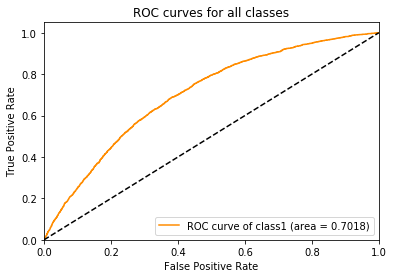

In [296]:
plot_roc(y_pred, y_true)

## Train with One-Hot-Encoding

In [55]:
DX1_cat = preprocessed['DX1_cat']
DX_cat = preprocessed['DX_cat']
PR_cat = preprocessed['PR_cat']
DX1_dict = preprocessed['DX1_dict']
DX_dict = preprocessed['DX_dict']
PR_dict = preprocessed['PR_dict']
code_cat = preprocessed['code_cat']
hosp_cat = preprocessed['hosp_cat']
age_mean = train_df0['AGE'].mean()
age_std = train_df0['AGE'].std()
los_mean = train_df0['LOS'].mean()
los_std = train_df0['LOS'].std()

In [32]:
code_mat_tst = tst_df[['DX1']+DXs+PRs].values
code_ohe_tst = np.zeros((len(tst_df), len(code_cat)))
for i in range(code_mat_tst.shape[0]):
    for j in range(code_mat_tst.shape[1]):
        if not code_mat_tst[i,j]==0:
            code_ohe_tst[i, code_mat_tst[i,j]] = 1.

In [56]:
hosp_array_tst = tst_df['HOSP_NRD'].values
hosp_ohe_tst = np.zeros((len(tst_df), len(hosp_cat)))
for j, hosp in enumerate(hosp_array_tst):
    hosp_ohe_tst[j, hosp] = 1.

In [59]:
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std
pay1_mat_tst = to_categorical(tst_df.PAY1.values)[:, 1:]
los_array_tst = (tst_df.LOS.values - los_mean)/los_std
ed_mat_tst = to_categorical(tst_df.HCUP_ED.values)
zipinc_mat_tst = to_categorical(tst_df.ZIPINC_QRTL.values)[:, 1:]
transfer_mat_tst = to_categorical(tst_df.SAMEDAYEVENT.values)
other_mat_tst = np.concatenate((demo_mat_tst, pay1_mat_tst, los_array_tst.reshape(los_array_tst.shape+(1,)), 
                                ed_mat_tst, zipinc_mat_tst, transfer_mat_tst), axis=1)
y_true = tst_df.readm30.astype(int).values

In [63]:
n_fold=3

In [64]:
skf = StratifiedKFold(n_splits=n_fold, random_state=24, shuffle=True)

In [65]:
trn_idx, val_idx = next(skf.split(train_df0, train_df0.HOSP_NRD))

In [69]:
train_df = train_df0.copy()

In [85]:
code_mat_train = train_df[['DX1']+DXs+PRs].values
code_ohe_train = np.zeros((len(train_df), len(code_cat)))
for i in range(code_mat_train.shape[0]):
    for j in range(code_mat_train.shape[1]):
        if not code_mat_train[i,j]==0:
            code_ohe_train[i, code_mat_train[i,j]] = 1.
            
code_ohe_trn = code_ohe_train[trn_idx, :]
code_ohe_val = code_ohe_train[val_idx, :]

In [73]:
hosp_array_train = train_df['HOSP_NRD'].values
hosp_ohe_train = np.zeros((len(train_df), len(hosp_cat)))
for j, hosp in enumerate(hosp_array_train):
    hosp_ohe_train[j, hosp] = 1.
    
hosp_ohe_trn = hosp_ohe_train[trn_idx, :]
hosp_ohe_val = hosp_ohe_train[val_idx, :]

In [75]:
demo_mat_train = train_df[['AGE', 'FEMALE']].values
demo_mat_train[:, 0] = (demo_mat_train[:, 0]-age_mean)/age_std
pay1_mat_train = to_categorical(train_df.PAY1.values)[:, 1:]
los_array_train = (train_df.LOS.values - los_mean)/los_std
ed_mat_train = to_categorical(train_df.HCUP_ED.values)
zipinc_mat_train = to_categorical(train_df.ZIPINC_QRTL.values)[:, 1:]
transfer_mat_train = to_categorical(train_df.SAMEDAYEVENT.values)
other_mat_train = np.concatenate((demo_mat_train, pay1_mat_train, los_array_train.reshape(los_array_train.shape+(1,)), 
                                ed_mat_train, zipinc_mat_train, transfer_mat_train), axis=1)

other_mat_trn = other_mat_train[trn_idx, :]
other_mat_val = other_mat_train[val_idx, :]

y_train = train_df.readm30.astype(int).values
Y_trn = to_categorical(y_train[trn_idx])
Y_val = to_categorical(y_train[val_idx])

### Model Building

In [93]:
fc_width1 = 1024
fc_width2 = 256
dropout = 0.3
lr = 1e-4
batchsize = 512

In [94]:
input_code = Input(shape = (len(code_cat),))
input_hosp = Input(shape=(len(hosp_cat),))
input_other = Input(shape=(other_mat_train.shape[1], ))

merged = Concatenate(axis=1)([input_code, input_hosp, input_other])

x = Dense(fc_width1, activation='relu')(merged)
x = Dense(fc_width2, activation='relu')(x)
x = Dropout(dropout)(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_code, input_hosp, input_other], outputs=prediction)

In [95]:
adam = Adam(lr=lr)
model.compile(optimizer=adam, loss='categorical_crossentropy')    

In [96]:
auccheckpoint = AUCCheckPoint(filepath=model_path+'ohe_temp.h5', validation_y=Y_val[:, 1], 
                            validation_x=[code_ohe_val, hosp_ohe_val, other_mat_val])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [97]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [98]:
hist = model.fit([code_ohe_trn, hosp_ohe_trn, other_mat_trn], Y_trn, 
                     batch_size=batchsize, epochs=5, callbacks=[auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                     validation_data=[[code_ohe_val, hosp_ohe_val, other_mat_val], Y_val], verbose=1)

Train on 111558 samples, validate on 56283 samples
Epoch 1/5
111558/111558 [==============================] - 6s 55us/step - loss: 1.2705 - val_loss: 0.6081
AUC: 0.7145

Epoch 2/5
111558/111558 [==============================] - 5s 47us/step - loss: 1.2121 - val_loss: 0.6304
AUC: 0.7153

Epoch 3/5
111558/111558 [==============================] - 5s 47us/step - loss: 1.1628 - val_loss: 0.6129
AUC: 0.7097

Epoch 4/5
111558/111558 [==============================] - 5s 47us/step - loss: 1.0916 - val_loss: 0.6359
AUC: 0.6957

Epoch 5/5
111558/111558 [==============================] - 5s 47us/step - loss: 0.9802 - val_loss: 0.5691
AUC: 0.6664



In [99]:
model.load_weights(model_path+'ohe_temp.h5')

In [100]:
y_output = model.predict([code_ohe_tst, hosp_ohe_tst, other_mat_tst], verbose=0)  

In [104]:
y_pred = y_output[:, 1]
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

In [105]:
roc_auc

0.7117707427053499

### backups

Define the dictionaries for DX, DX1 and hosp, from value to int. 

In [9]:
freq = get_frequency(train_df0)

In [10]:
unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])

In [11]:
DX_rarecutpoint = 10
PR_rarecutpoint = 10

In [12]:
DX1_cat = sorted(freq['DX1'].index)
DX_cat = sorted(freq['DX'].loc[(freq['DX']>DX_rarecutpoint) & (~freq['DX'].index.isin(unclassified)) & 
                               (~freq['DX'].index.isin(['invl', 'incn']))].index)
PR_cat = sorted(freq['PR'].loc[(freq['PR']>PR_rarecutpoint) & (~freq['PR'].index.isin(['invl', 'incn']))].index)

In [14]:
len(DX1_cat), len(DX_cat), len(PR_cat)

(20, 2231, 413)

In [13]:
dx1_multi_sub = dx_multi.loc[dx_multi.ICD9CM_CODE.isin(DX1_cat)]
dx1_ccs_cat = sorted(pd.concat([dx1_multi_sub['CCS_LVL'+str(j)] for j in range(1, 5)]).unique())
if '' in dx1_ccs_cat:
    dx1_ccs_cat.remove('')
dx_multi_sub = dx_multi.loc[dx_multi.ICD9CM_CODE.isin(DX_cat)]
dx_ccs_cat = sorted(pd.concat([dx_multi_sub['CCS_LVL'+str(j)] for j in range(1, 5)]).unique())
if '' in dx_ccs_cat:
    dx_ccs_cat.remove('')

pr_multi_sub = pr_multi.loc[pr_multi.ICD9CM_CODE.isin(PR_cat)]
pr_ccs_cat = sorted(pd.concat([pr_multi_sub['CCS_LVL'+str(j)] for j in range(1, 4)]).unique())
if '' in pr_ccs_cat:
    pr_ccs_cat.remove('')

In [14]:
code_cat = DX1_cat+DX_cat+PR_cat+dx1_ccs_cat+dx_ccs_cat+pr_ccs_cat

In [15]:
DX1_dict = dict(zip(DX1_cat, range(1, len(DX1_cat)+1)))
DX_dict = dict(zip(DX_cat, range(len(DX1_cat)+1, len(DX1_cat)+len(DX_cat)+1)))
PR_dict = dict(zip(PR_cat, range(len(DX1_cat)+len(DX_cat)+1, len(DX1_cat)+len(DX_cat)+len(PR_cat)+1)))
DX1_dict['missing'] = 0
DX_dict['missing'] = 0
PR_dict['missing'] = 0
dx1_ccs_dict = dict(zip(dx1_ccs_cat, range(len(DX1_cat)+len(DX_cat)+len(PR_cat)+1, 
                                          len(DX1_cat)+len(DX_cat)+len(PR_cat)+len(dx1_ccs_cat)+1)))
dx_ccs_dict = dict(zip(dx_ccs_cat, range(len(DX1_cat)+len(DX_cat)+len(PR_cat)+len(dx1_ccs_cat)+1, 
                                         len(DX1_cat)+len(DX_cat)+len(PR_cat)+len(dx1_ccs_cat)+len(dx_ccs_cat)+1)))
pr_ccs_dict = dict(zip(pr_ccs_cat, range(len(DX1_cat)+len(DX_cat)+len(PR_cat)+len(dx1_ccs_cat)+len(dx_ccs_cat)+1, 
                                        len(DX1_cat)+len(DX_cat)+len(PR_cat)+len(dx1_ccs_cat)+len(dx_ccs_cat)+len(pr_ccs_cat)+1)))

In [16]:
hosp_cat = sorted(all_df['HOSP_NRD'].value_counts().index)
hosp_dict = dict(zip(hosp_cat, range(len(hosp_cat))))

In [18]:
int_df = all_df.copy()

In [19]:
int_df.loc[~int_df.DX1.isin(DX1_cat), 'DX1'] = 'missing'

int_df['DX1'] = int_df['DX1'].map(DX1_dict)

In [20]:
for dx in DXs:
    int_df.loc[~int_df[dx].isin(DX_cat), dx] = 'missing'
    int_df[dx] = int_df[dx].map(DX_dict)

In [21]:
for pr in PRs:
    int_df.loc[~int_df[pr].isin(PR_cat), pr] = 'missing'
    int_df[pr] = int_df[pr].map(PR_dict)

In [22]:
int_df['HOSP_NRD'] = int_df['HOSP_NRD'].map(hosp_dict)